# Grocery Recommendation Project

1. Data Clustering on users  
2. Recommendation systems
  * Content-based filtering  
  * Collaborative filtering  
3. Metadata NLP search engine
4. Market Basket analysis  
4. Website interface  

For this analysis I will be working as a Data Scientist for a grocery store that is looking to discover insights from sales data that could be used for targeted direct mail marketing (specific coupons mailed to customers), targeted email marketing ("An item you like has gone on sale!"), and online shopper recommendations to 'add to cart' based on similar items and also based on items other people who bought that item have purchased.  

If time permits, I may also perform a market basket analysis to forecast what products a customer is likely to purchase in their next order.

## Dataset information

This data was retrieved from Kaggle and was provided by Instacart for a market basket analysis competition in 2018.  

The data is divided into 6 files:

- **_Aisles.csv_**: 134 Unique aisle numbers and descriptions
- **_Departments.csv_**: 21 Unique department numbers and descriptions
- **_Products.csv_**: 49,688 Unique product ids, with description, aisle id, and department id
- **_Orders.csv_**: 3,421,083 Unique order id, with user id, order number, order_dow, order_hour_of_day, days_since_prior_order, and eval_set indicating if the order is in train, prior, or test
- **_Order_products_train.csv_**: Order id, product id, add to cart order, and reorder indicator
- **_Order_products_prior.csv_**: Order id, product id, add to cart order, and reorder indicator


## EDA and Data Preprocessing

See separate notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from user_functions import *
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Clustering

In [3]:
# Now I want to experiment with clustering the 'similar' users together
# But what data do I need for each user?  Some kind of summary statistics?
# I guess I need each product to be a column, with the number of times it was ordered?
# Product level is too granular so I am going to try aisle

In [4]:
merged_orders = pickle.load(open("Pickle/merged_orders.p", "rb"))

In [5]:
merged_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [6]:
# What don't I need for my user dataframe?
# Since product level is too granular, I will capture the aisle
user_info = merged_orders[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 
                           'days_since_prior_order', 'aisle']]

In [7]:
user_info.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,1,1,2,8,NaN,soft drinks
1,1,1,2,8,NaN,popcorn jerky
2,1,1,2,8,NaN,soy lactosefree
3,1,1,2,8,NaN,paper goods
4,1,1,2,8,NaN,popcorn jerky


### Get dummy variables for each aisle

In [8]:
user_data = pd.get_dummies(user_info, prefix=None, columns=['aisle'])

In [9]:
user_data
# Group By User_id
# I need max of order_number
# Mode of order_dow, median of order_hour_of_day, mean of days_since
# Sum of each aisle

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819102,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819103,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819104,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
user_data['aisle_soft drinks'].value_counts()

0    33445290
1      373816
Name: aisle_soft drinks, dtype: int64

### Group By each User Id

In [11]:
# Splitting the data in thirds to use groupby then will rejoin them
user_data1 = user_data[user_data['user_id'] <= 65000]
user_data2 = user_data[(user_data['user_id'] <= 135000) & (user_data['user_id'] > 65000)]
user_data3 = user_data[user_data['user_id'] > 135000]

In [12]:
grouped_user1 = user_data1.groupby('user_id').sum()

In [13]:
grouped_user2 = user_data2.groupby('user_id').sum()

In [14]:
grouped_user3 = user_data3.groupby('user_id').sum()

In [15]:
# Go back to user_data and drop the aisle info before I group the other variables in different ways
user_data1_noaisles = user_data1.iloc[:,:5]
user_data2_noaisles = user_data2.iloc[:,:5]
user_data3_noaisles = user_data3.iloc[:,:5]

In [16]:
# Cool.  Found a way to group each varaiable differently.
group1 = user_data1_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group2 = user_data2_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group3 = user_data3_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})

In [17]:
group1

,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,
1,11,4,8.0,19.200000
2,15,1,10.0,18.009390
3,12,0,16.0,11.487179
4,5,4,13.0,15.357143
5,5,0,16.0,12.314286
...,...,...,...,...
64996,15,2,14.0,17.057143
64997,5,0,11.0,20.869048
64998,4,5,10.0,24.521739


In [18]:
# get number of orders for each user and add to grouped_user dfs
grouped_user1['num_orders'] = group1.order_number
grouped_user2['num_orders'] = group2.order_number
grouped_user3['num_orders'] = group3.order_number

In [19]:
grouped_user1['mean_days_since'] = group1.days_since_prior_order
grouped_user2['mean_days_since'] = group2.days_since_prior_order
grouped_user3['mean_days_since'] = group3.days_since_prior_order

In [20]:
grouped_user1['mode_order_dow'] = group1.order_dow
grouped_user2['mode_order_dow'] = group2.order_dow
grouped_user3['mode_order_dow'] = group3.order_dow

In [21]:
grouped_user1['median_order_hour'] = group1.order_hour_of_day
grouped_user2['median_order_hour'] = group2.order_hour_of_day
grouped_user3['median_order_hour'] = group3.order_hour_of_day

In [22]:
grouped_user1.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user2.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user3.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)

In [23]:
grouped_users = pd.concat([grouped_user1, grouped_user2, grouped_user3], axis=0)

In [24]:
grouped_users

,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,...,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,num_orders,mean_days_since,mode_order_dow,median_order_hour
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,11,19.200000,4,8.0
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,42.0,15,18.009390,1,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,12,11.487179,0,16.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5,15.357143,4,13.0
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,5,12.314286,0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,4,14.705882,1,16.0
206206,0.0,4.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,67,4.042705,0,18.0
206207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,11.0,0.0,15.0,16,14.879397,1,12.0


In [25]:
# This function came from a Medium article by Adam Ross Nelson to rearrange columns in a df
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [26]:
grouped_users = movecol(grouped_users, 
             cols_to_move=['num_orders', 'mode_order_dow', 'median_order_hour', 'mean_days_since'], 
             ref_col='aisle_air fresheners candles',
             place='Before')
grouped_users

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,4,8.0,19.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,15,1,10.0,18.009390,0.0,3.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
3,12,0,16.0,11.487179,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,5,4,13.0,15.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,0,16.0,12.314286,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,4,1,16.0,14.705882,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
206206,67,0,18.0,4.042705,0.0,4.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
206207,16,1,12.0,14.879397,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,4.0,0.0,2.0,1.0,0.0,0.0,11.0,0.0,15.0


In [27]:
pickle.dump(grouped_users, open("Pickle/grouped_users.p", "wb"))

### Run KMeans clustering

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_users = scaler.fit_transform(grouped_users)

In [29]:
scaled_users

array([[-0.31368362,  0.63094204, -1.98290635, ..., -0.37143228,
        -0.08668691, -0.28458752],
       [-0.07361924, -0.75026401, -1.26590407, ..., -0.19699129,
        -0.08668691,  1.85881583],
       [-0.25366752, -1.21066602,  0.88510277, ..., -0.19699129,
        -0.08668691, -0.39175769],
       ...,
       [-0.01360315, -0.75026401, -0.54890179, ...,  0.58799319,
        -0.08668691,  0.41201857],
       [ 1.96692792, -0.28986199,  0.16810049, ..., -0.37143228,
        -0.08668691,  1.37655008],
       [-0.13363534, -0.75026401, -0.54890179, ..., -0.37143228,
        -0.08668691, -0.23100244]])

In [30]:
from sklearn.cluster import KMeans
random_state = 12

'''The classical EM-style algorithm is “full”. The “elkan” variation is more efficient on data with well-defined clusters,
by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape 
(n_samples, n_clusters).'''

# Is having 20 separate market segments helpful?  Can I figure out what make them different and target that?  

k_means_13 = KMeans(n_clusters=13, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_14 = KMeans(n_clusters=14, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_15 = KMeans(n_clusters=15, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_16 = KMeans(n_clusters=16, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_17 = KMeans(n_clusters=17, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_18 = KMeans(n_clusters=18, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_19 = KMeans(n_clusters=19, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_10 = KMeans(n_clusters=10, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_11 = KMeans(n_clusters=11, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_12 = KMeans(n_clusters=12, random_state=random_state, algorithm='full').fit(scaled_users)
# k_means_20 = KMeans(n_clusters=20, random_state=random_state, algorithm='full').fit(scaled_users)


In [31]:
# pickle.dump(k_means_20, open("Pickle/k_means_20.p", "wb"))

In [32]:
k_means_20 = pickle.load(open("Pickle/k_means_20.p", "rb"))

In [33]:
k_list = [k_means_10, k_means_11, k_means_12, k_means_13, 
          k_means_14, k_means_15, k_means_16, k_means_17, k_means_18, k_means_19, k_means_20]

In [34]:
from sklearn.metrics import calinski_harabasz_score

CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(grouped_users, labels))

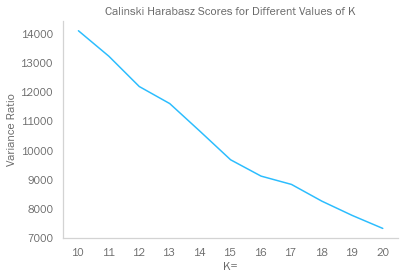

In [35]:
# Need to decide if I keep going with more clusters
# Previous k_means_20 on unscaled data had CH around 16000, now scaled it is at 8000

plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], CH_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.savefig('Images/ch_scaled_scores.png');

In [36]:
# Looking at Within Cluster Sum of Squares

wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

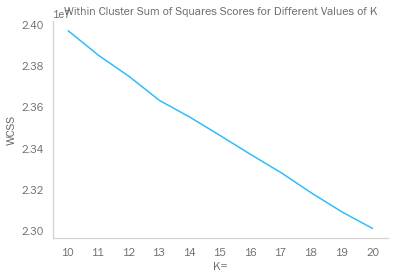

In [37]:
plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], wcss_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Within Cluster Sum of Squares Scores for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.savefig('Images/wcss_scores.png');

In [38]:
# Silhouette score 1 is good, -1 is bad, near 0 means overlapping custers

from sklearn import metrics
metrics.silhouette_score(grouped_users, k_means_20.labels_, sample_size = 30000, random_state = random_state)

0.1716260835041877

In [39]:
metrics.silhouette_score(grouped_users, k_means_19.labels_, sample_size = 30000, random_state = random_state)

0.17220397175003255

In [40]:
# OK let's focus on k_means_20 and have a look at our clusters

k_means_20.labels_

array([12,  1, 12, ...,  1,  6,  1])

In [41]:
# Add cluster assignment to the grouped_users dataframe
grouped_users['cluster'] = k_means_20.labels_

### Analyze clusters

In [42]:
# There are top 3 big clusters and lots of smaller.  May be hard to determine what the big clusters have in common.
grouped_users.cluster.value_counts()

12    112042
1      47053
4      16295
18      9216
3       4569
6       4058
14      3282
10      1967
8       1345
5        938
16       905
2        854
13       742
9        673
19       641
11       608
0        489
17       246
7        154
15       132
Name: cluster, dtype: int64

In [43]:
# Now take the grouped users and group them by cluster

# For each user, I took the mode of their order_dow.  Now I am taking the median value for the cluster.

# cluster_data = grouped_users.groupby('cluster').agg({'num_orders': 'median', 
#                                                      'mode_order_dow': lambda x:x.value_counts().index[0], 
#                                                      'median_order_hour': 'median', 'mean_days_since': 'mean'})
cluster_data = grouped_users.groupby('cluster').median()

In [44]:
cluster_data # This is the median info for each cluster

# I can see cluster 7 has a lot of baby products

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,41.0,2.0,13.0,8.071685,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,11.0
1,14.0,2.0,14.0,13.491803,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
2,57.0,2.0,11.0,6.180689,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,20.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,61.0
3,29.0,2.0,13.5,10.267296,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,8.0
4,30.0,1.0,13.0,9.890710,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,11.0
5,33.0,2.0,14.0,9.842865,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0
6,46.0,1.0,13.0,7.703537,0.0,1.0,0.0,0.0,2.5,0.0,...,4.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,30.0
7,55.0,2.0,13.0,6.311090,0.0,1.0,12.5,0.0,7.0,0.0,...,4.0,2.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,22.5
8,65.0,1.0,13.0,5.976703,0.0,4.0,0.0,0.0,1.0,0.0,...,10.0,2.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,44.0


In [45]:
# These are the users that make up cluster 7, and yes they have a lot of baby products

grouped_users[grouped_users['cluster'] == 7]

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
313,100,5,8.0,2.236200,0.0,1.0,27.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7
652,95,4,15.0,3.734280,0.0,0.0,24.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,7
1022,79,3,15.0,4.215146,0.0,2.0,9.0,0.0,89.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,11.0,7
3639,17,2,16.0,3.702238,2.0,1.0,10.0,0.0,15.0,0.0,...,0.0,0.0,2.0,5.0,1.0,1.0,24.0,0.0,13.0,7
4425,26,1,14.0,9.049724,0.0,0.0,9.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200275,47,4,12.0,8.133333,0.0,22.0,7.0,0.0,58.0,0.0,...,31.0,0.0,0.0,0.0,5.0,0.0,34.0,0.0,7.0,7
201043,37,5,11.0,8.781250,0.0,0.0,15.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,7
201185,89,6,13.0,4.622980,0.0,3.0,15.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,2.0,0.0,31.0,0.0,1.0,7


In [46]:
# These are all of cluster 7's values that aren't zero... still 62 of them

cluster_data.iloc[7,(cluster_data.loc[7].values > 0)]

num_orders                             55.00000
mode_order_dow                          2.00000
median_order_hour                      13.00000
mean_days_since                         6.31109
aisle_asian foods                       1.00000
                                         ...   
aisle_spreads                           4.00000
aisle_tea                               2.00000
aisle_tortillas flat bread              1.00000
aisle_water seltzer sparkling water     9.00000
aisle_yogurt                           22.50000
Name: 7, Length: 62, dtype: float64

### Use TSNE to convert cluster data to 3D

In [78]:
# Convert to three dimensional for graphing

from sklearn.manifold import TSNE

cluster_embedded = TSNE(n_components=3).fit_transform(cluster_data)

In [79]:
# Create dataframe to plot
cluster_embedded_df = pd.DataFrame(cluster_embedded, index = cluster_data.index, columns = ['1','2','3'])
cluster_embedded_df.reset_index(inplace=True)
cluster_embedded_df

,cluster,1,2,3
0,0,361.596802,-120.465057,74.153030
1,1,-218.084412,49.047455,-119.207275
2,2,23.063705,46.574062,-258.280243
3,3,120.292252,-137.083267,146.071411
4,4,-172.475967,-175.008026,-44.621735
5,5,-18.599131,-32.137333,-84.543236
6,6,219.152313,174.451111,-23.628244
7,7,223.733139,5.485920,71.572662
8,8,-42.375885,-50.616161,92.938797
9,9,-224.833252,-8.456332,81.855171


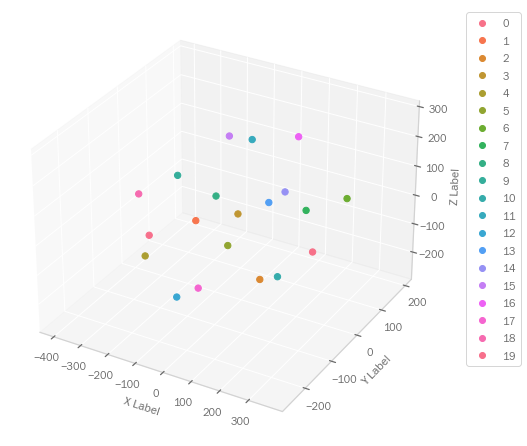

In [80]:
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(cluster_embedded_df['1'], cluster_embedded_df['2'], cluster_embedded_df['3'], 
                s=40, c=cluster_embedded_df['cluster'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(num=20), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("Images/scatter_hue.png", bbox_inches='tight')

In [81]:
# This shows clusters 5, 11, 12, 14, and 17 as being very separate from the rest

import plotly.express as px

fig = px.scatter_3d(cluster_embedded_df, x='1', y='2', z='3', color='cluster')
fig.show()

In [72]:
# Can I plot all of the users with their cluster color?
# This took about 2 hours and 20 minutes to run.

# user_embedded = TSNE(n_components=3).fit_transform(grouped_users.drop(columns='cluster'))

In [73]:
# pickle.dump(user_embedded, open("Pickle/user_embedded.p", "wb"))

In [74]:
user_embedded = pickle.load(open("Pickle/user_embedded.p", "rb"))

In [75]:
user_embedded

array([[-10.520423  ,   5.5322037 ,  -6.7056575 ],
       [  1.3855914 ,  -7.02455   ,   9.568875  ],
       [ -4.5315447 ,  17.108244  ,  -0.95370793],
       ...,
       [ 12.564502  ,  -5.956699  ,   5.5301633 ],
       [  3.9598756 , -13.028995  ,   9.51385   ],
       [ -0.7554037 ,   1.6710486 ,   3.1855068 ]], dtype=float32)

In [76]:
# Create dataframe to plot
user_embedded_df = pd.DataFrame(user_embedded, index = grouped_users.index, columns = ['1','2','3'])
user_embedded_df.reset_index(inplace=True)
user_embedded_df['cluster'] = k_means_20.labels_
user_embedded_df

,user_id,1,2,3,cluster
0,1,-10.520423,5.532204,-6.705657,12
1,2,1.385591,-7.024550,9.568875,1
2,3,-4.531545,17.108244,-0.953708,12
3,4,1.117579,-10.682834,2.378677,12
4,5,-5.401272,-2.868390,-11.791850,12
...,...,...,...,...,...
206204,206205,-11.365388,-3.931187,-4.361998,12
206205,206206,7.169143,-11.028357,1.820490,4
206206,206207,12.564502,-5.956699,5.530163,1
206207,206208,3.959876,-13.028995,9.513850,6


In [77]:
fig = px.scatter_3d(user_embedded_df.sample(200), x='1', y='2', z='3', color='cluster')
fig.show()

### Cluster Breakdown by Aisle

In [57]:
# Create a way to compare clusters.  Find if they have max or min values for any features.

cluster_metrics = {}
for cluster in cluster_data.index:
    cluster_list = [grouped_users.cluster.value_counts()[cluster]]
    for col in cluster_data.columns:
        if (cluster_data.loc[:,col].max() > 0) & (cluster_data.loc[:,col].idxmax() == cluster):
            cluster_list.append(('max ' + col, cluster_data.loc[cluster,col]))
        if (cluster_data.loc[:,col].min() > 0) & (cluster_data.loc[:,col].idxmin() == cluster):
                cluster_list.append(('min ' + col, cluster_data.loc[cluster,col]))
    cluster_metrics[cluster] = cluster_list

In [58]:
cluster_metrics

{0: [489, ('max aisle_packaged meat', 13.0)],
 1: [47053, ('max median_order_hour', 14.0)],
 2: [854,
  ('min median_order_hour', 11.0),
  ('max aisle_chips pretzels', 26.0),
  ('max aisle_coffee', 4.0),
  ('max aisle_cream', 14.0),
  ('max aisle_energy granola bars', 29.0),
  ('max aisle_granola', 4.0),
  ('max aisle_honeys syrups nectars', 1.0),
  ('max aisle_popcorn jerky', 2.0),
  ('max aisle_soy lactosefree', 15.0),
  ('max aisle_tea', 20.0),
  ('max aisle_water seltzer sparkling water', 33.0),
  ('max aisle_yogurt', 61.0)],
 3: [4569,
  ('max aisle_doughs gelatins bake mixes', 2.0),
  ('max aisle_frozen meals', 3.0),
  ('max aisle_frozen pizza', 1.0),
  ('max aisle_marinades meat preparation', 1.0),
  ('max aisle_salad dressing toppings', 1.0)],
 4: [16295, ('min mode_order_dow', 1.0)],
 5: [938,
  ('max aisle_body lotions soap', 5.0),
  ('max aisle_cold flu allergy', 1.0),
  ('max aisle_deodorants', 1.0),
  ('max aisle_eye ear care', 1.0),
  ('max aisle_facial care', 2.0),
  ('m

In [59]:
# Clusters 5, 11, 12, 14, and 17 looked very separate from the rest on the graph.

print(cluster_metrics[5]) # Lots of personal care / pharmacy type products
print(cluster_metrics[11]) # Soap and skin care
print(cluster_metrics[12]) # Very large cluster, with fewest number of orders and highest days between orders
print(cluster_metrics[14]) # Tons of veggies, herb, and spices
print(cluster_metrics[17]) # Bulk dried fruits and veggies

[938, ('max aisle_body lotions soap', 5.0), ('max aisle_cold flu allergy', 1.0), ('max aisle_deodorants', 1.0), ('max aisle_eye ear care', 1.0), ('max aisle_facial care', 2.0), ('max aisle_feminine care', 1.0), ('max aisle_hair care', 2.0), ('max aisle_oral hygiene', 4.0), ('max aisle_shave needs', 1.0)]
[608, ('max aisle_skin care', 5.0), ('max aisle_soap', 4.0), ('max aisle_vitamins supplements', 1.0)]
[112042, ('min num_orders', 6.0), ('max mean_days_since', 18.872983354673494), ('min aisle_fresh fruits', 4.0), ('min aisle_packaged cheese', 1.0), ('min aisle_packaged vegetables fruits', 2.0)]
[3282, ('max aisle_canned jarred vegetables', 9.0), ('max aisle_fresh herbs', 16.0), ('max aisle_fresh vegetables', 119.0), ('max aisle_spices seasonings', 6.0)]
[246, ('max aisle_bulk dried fruits vegetables', 17.0)]


In [60]:
#Other interesting clusters

print(cluster_metrics[7]) # Baby products
print(cluster_metrics[8]) # Lots of orders, shortest days between, big buyers
print(cluster_metrics[9]) # Alcohol purchasers
print(cluster_metrics[13]) # Household, laundry, cleaning products
print(cluster_metrics[15]) # Chocolate, gum and soft drinks, least veggies
print(cluster_metrics[16]) # Vegan and tofu

[154, ('max aisle_baby accessories', 12.5), ('max aisle_baby food formula', 7.0), ('max aisle_diapers wipes', 1.0)]
[1345, ('max num_orders', 65.0), ('min mean_days_since', 5.976702508960574), ('max aisle_asian foods', 4.0), ('max aisle_baking ingredients', 10.0), ('max aisle_bread', 25.0), ('max aisle_breakfast bakery', 5.0), ('max aisle_buns rolls', 2.0), ('max aisle_butter', 8.0), ('max aisle_canned fruit applesauce', 1.0), ('max aisle_canned meals beans', 9.0), ('max aisle_cereal', 10.0), ('max aisle_condiments', 6.0), ('max aisle_cookies cakes', 4.0), ('max aisle_crackers', 17.0), ('max aisle_dry pasta', 12.0), ('max aisle_eggs', 11.0), ('max aisle_fresh dips tapenades', 9.0), ('max aisle_fresh fruits', 133.0), ('max aisle_frozen appetizers sides', 6.0), ('max aisle_frozen breakfast', 6.0), ('max aisle_frozen meat seafood', 1.0), ('max aisle_frozen produce', 14.0), ('max aisle_fruit vegetable snacks', 4.0), ('max aisle_grains rice dried goods', 4.0), ('max aisle_hot cereal pancake

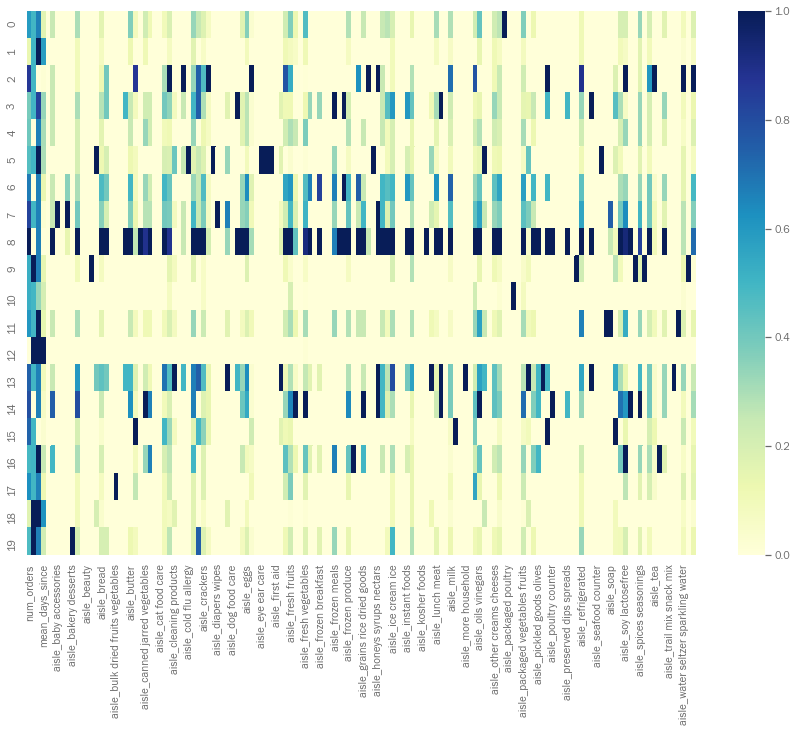

In [61]:
# Make a heatmap of clusters and aisles
# Scale the data first to make it more meaningful
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
graph_data = scaler.fit_transform(cluster_data)
graph_df=pd.DataFrame(graph_data, columns = cluster_data.columns)
fig = plt.figure(figsize=(15,10))
heat_map = sns.heatmap(graph_df, cmap="YlGnBu")
plt.savefig('Images/cluster_heatmap.png')

In [62]:
# Can I write a function to predict what cluster someone will belong in?
# They would have to give me a shopping list... no even then some clusters may be based on order frequency rather than item.
# Or rather, if they give me an item, can I ouput "Others who bought this item also bought..."
# That we will get from the recommendation system below I think

### Cluster Buying Power

In [63]:
# Add up all of the products for each person

grouped_users['num_products'] = grouped_users[grouped_users.columns[4:-1]].sum(axis=1)

In [64]:
# This will be used to count how many users are in each cluster when I do the groupby
grouped_users['user_count'] = list(np.ones(len(grouped_users)))

In [65]:
grouped_users = movecol(grouped_users, 
                        cols_to_move=['num_products', 'user_count', 'cluster'], 
                        ref_col='mode_order_dow', 
                        place='Before')
grouped_users

,num_orders,num_products,user_count,cluster,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,70.0,1.0,12,4,8.0,19.200000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,15,226.0,1.0,1,1,10.0,18.009390,0.0,3.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
3,12,88.0,1.0,12,0,16.0,11.487179,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,5,18.0,1.0,12,4,13.0,15.357143,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,46.0,1.0,12,0,16.0,12.314286,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,4,51.0,1.0,12,1,16.0,14.705882,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
206206,67,285.0,1.0,4,0,18.0,4.042705,0.0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
206207,16,223.0,1.0,1,1,12.0,14.879397,0.0,0.0,0.0,...,3.0,4.0,0.0,2.0,1.0,0.0,0.0,11.0,0.0,15.0


In [66]:
# Group by cluster, adding up the number of products purchased
grouped_clusters = grouped_users.groupby('cluster').sum()
grouped_clusters

,num_orders,num_products,user_count,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,22099,264115.0,489.0,1227,6521.5,4.273126e+03,103.0,1122.0,34.0,71.0,...,2088.0,1573.0,432.0,1476.0,190.0,149.0,382.0,5129.0,66.0,9958.0
1,785071,7788280.0,47053.0,113938,638697.5,6.504607e+05,2546.0,43799.0,1335.0,1327.0,...,69810.0,58495.0,32274.0,47178.0,5417.0,4501.0,10244.0,201047.0,4629.0,359427.0
2,53338,754548.0,854.0,2051,9867.0,5.270373e+03,269.0,2446.0,9.0,12.0,...,8370.0,30309.0,496.0,954.0,2072.0,271.0,879.0,50692.0,118.0,86146.0
3,146839,1862032.0,4569.0,12301,61678.0,5.023833e+04,1865.0,8346.0,191.0,535.0,...,16065.0,13280.0,1802.0,14305.0,1624.0,2809.0,1273.0,37724.0,1923.0,65578.0
4,542910,5951742.0,16295.0,38280,218515.0,1.700525e+05,1155.0,33502.0,948.0,1176.0,...,53388.0,38901.0,26071.0,35799.0,3023.0,2490.0,8781.0,130922.0,758.0,279863.0
5,34338,347793.0,938.0,2572,12886.5,1.022870e+04,1907.0,1329.0,125.0,396.0,...,2898.0,2562.0,351.0,2011.0,394.0,1008.0,776.0,10751.0,233.0,12151.0
6,201588,2797103.0,4058.0,8301,53617.0,3.312681e+04,353.0,10156.0,702.0,890.0,...,26853.0,12953.0,6430.0,18990.0,2465.0,1110.0,3470.0,52812.0,170.0,159247.0
7,8934,122688.0,154.0,409,2041.5,1.052266e+03,82.0,676.0,2302.0,129.0,...,1158.0,1182.0,797.0,936.0,54.0,160.0,353.0,2511.0,9.0,4980.0
8,90579,1653446.0,1345.0,2968,17363.5,8.187579e+03,214.0,9376.0,320.0,558.0,...,16997.0,8826.0,6179.0,14026.0,1251.0,898.0,2775.0,25757.0,129.0,72825.0


In [67]:
# This doesn't take into account the relative prices of the items purchased
# But we can now see the portion of products purchased by each cluster
cluster_power = grouped_clusters.iloc[:,0:3]

In [68]:
cluster_power

,num_orders,num_products,user_count
cluster,,,
0,22099,264115.0,489.0
1,785071,7788280.0,47053.0
2,53338,754548.0,854.0
3,146839,1862032.0,4569.0
4,542910,5951742.0,16295.0
5,34338,347793.0,938.0
6,201588,2797103.0,4058.0
7,8934,122688.0,154.0
8,90579,1653446.0,1345.0


In [69]:
# Calculate ordering statistics per cluster
cluster_power['portion_of_orders'] = cluster_power['num_orders'].apply(lambda x: 
                                                                             x/(cluster_power['num_orders'].sum()))
cluster_power['portion_of_products'] = cluster_power['num_products'].apply(lambda x: 
                                                                                 x/(cluster_power['num_products'].sum()))
cluster_power['portion_of_users'] = cluster_power['user_count'].apply(lambda x: 
                                                                             x/(cluster_power['user_count'].sum()))
cluster_power['orders_per_user'] = cluster_power['num_orders']/cluster_power['user_count']
cluster_power['products_per_user'] = cluster_power['num_products']/cluster_power['user_count']

In [70]:
cluster_power.sort_values('products_per_user', ascending=False)

,num_orders,num_products,user_count,portion_of_orders,portion_of_products,portion_of_users,orders_per_user,products_per_user
cluster,,,,,,,,
8,90579,1653446.0,1345.0,0.027070,0.048891,0.006523,67.344981,1229.327881
2,53338,754548.0,854.0,0.015940,0.022311,0.004141,62.456674,883.545667
7,8934,122688.0,154.0,0.002670,0.003628,0.000747,58.012987,796.675325
13,40293,563544.0,742.0,0.012042,0.016663,0.003598,54.303235,759.493261
14,192427,2374227.0,3282.0,0.057508,0.070204,0.015916,58.631018,723.408592
6,201588,2797103.0,4058.0,0.060246,0.082708,0.019679,49.676688,689.281173
16,35667,507608.0,905.0,0.010659,0.015010,0.004389,39.411050,560.892818
15,7051,72868.0,132.0,0.002107,0.002155,0.000640,53.416667,552.030303
0,22099,264115.0,489.0,0.006604,0.007810,0.002371,45.192229,540.112474


In [71]:
'''Sorting these statistics different ways shows interesting results depending on what you are looking for.  We can see
that cluster 8 orders a very large number of products per user, but overall cluster 8 represents a small portion of all
of the users.  Cluster 12 represents over 50% of all of the users, but only 25% of the orders and only 17% of the products.
Cluster 1 is very proportional with about 23% of the users, orders, and products.  Cluster 4 is the third largest cluster
with 7% of the users, but they make up about 17% of the orders and products.'''

'Sorting these statistics different ways shows interesting results depending on what you are looking for.  We can see\nthat cluster 8 orders a very large number of products per user, but overall cluster 8 represents a small portion of all\nof the users.  Cluster 12 represents over 50% of all of the users, but only 25% of the orders and only 17% of the products.\nCluster 1 is very proportional with about 23% of the users, orders, and products.  Cluster 4 is the third largest cluster\nwith 7% of the users, but they make up about 17% of the orders and products.'